In [1]:
import os
import sys
from dateutil import parser
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.db import psql_connection

conn = psql_connection()
cursor = conn.cursor()

%matplotlib inline

### Top 10 Events

In [18]:
query = """
    SELECT type, COUNT(type) AS type_count
    FROM events
    GROUP BY type
    ORDER BY type_count DESC
    LIMIT 10;
"""
pd.read_sql_query(query, conn)

,type,type_count
0,Slide start,279962
1,Client error,160009
2,App Became Active,132801
3,View player page,110663
4,Land on Homepage,59170
5,Editor Opened,55485
6,Click Link,51527
7,Land on Pricing Page,25303
8,Display Limit Notification,17722
9,Deck Created,13802


### Top 25 Users with the most decks

In [20]:
query = """
    SELECT 
        users.email, 
        users.signup_at, 
        users.is_paying, 
        users.vertical,
        d.deck_count
    FROM users
    INNER JOIN (
        SELECT distinct_id, count(distinct_id) AS deck_count
        FROM events
        WHERE type = 'Deck Created'
        GROUP BY distinct_id
        ORDER BY deck_count DESC
        LIMIT 25
    ) AS d
    ON d.distinct_id = users.distinct_id;
"""

pd.read_sql_query(query, conn)

,email,signup_at,is_paying,vertical,deck_count
0,jbrittin@hammontonps.org,2017-06-01,True,educator,105
1,katherine.cherry@acps.k12.va.us,None,True,educator,47
2,haiku.claseiv@colegio-estudio.com,2017-06-19,True,educator,41
3,webbcubs@yahoo.com,2016-06-22,True,educator,38
4,adresseokoni6@gmail.com,2017-05-30,True,other,31
5,jose_cerda2@sbcglobal.net,None,False,None,30
6,drimnaghcastle.ias@gmail.com,None,False,None,24
7,DocMRich@aol.com,None,True,educator,22
8,adamt@tratt.com,2017-04-13,True,hr,22
9,associado.lucas@gmail.com,2017-06-06,True,student,21


### Visualizing Deck sizes

In [54]:
query = """
    SELECT 
        u.is_paying,
        d.deck_count
    FROM users AS u
    INNER JOIN (
        SELECT distinct_id, count(distinct_id) AS deck_count
        FROM events
        WHERE type = 'Deck Created'
        GROUP BY distinct_id
    ) AS d
    ON d.distinct_id = u.distinct_id;
    
"""
df = pd.read_sql_query(query, conn)
df.head()

,is_paying,deck_count
0,False,1
1,False,1
2,False,1
3,False,1
4,False,2


In [41]:
paying_df = df[df['is_paying'] == True]
not_paying_df = df[df['is_paying'] == False]

def log_deck_count(deck_count):
    return np.log(deck_count + 1)

for payment_df in [paying_df, not_paying_df]:
    payment_df['log_deck_count'] = payment_df['deck_count'].apply(log_deck_count)

/Users/timwhite/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


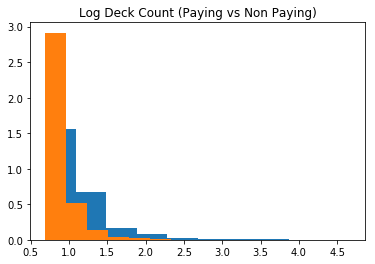

In [53]:
fig, ax = plt.subplots()
ax.hist(paying_df['log_deck_count'], normed=True)
ax.hist(not_paying_df['log_deck_count'], normed=True)
ax.set(title="Log Deck Count (Paying vs Non Paying)")
fig.show()

### Top events of paying and non-paying users

In [67]:
paying_events_query = """
SELECT 
    type AS event_type,
    count(type) AS event_count
FROM events AS e
INNER JOIN (
    SELECT distinct_id
    FROM users
    WHERE is_paying = TRUE
) AS d
ON d.distinct_id = e.distinct_id
GROUP BY type
ORDER BY event_count DESC;
"""

non_paying_query = """
    SELECT 
        type AS event_type,
        count(type) AS event_count
    FROM events AS e
    INNER JOIN (
        SELECT distinct_id
        FROM users
        WHERE is_paying = FALSE
    ) AS d
    ON d.distinct_id = e.distinct_id
    GROUP BY type
    ORDER BY event_count DESC;
"""
paying_df = pd.read_sql_query(paying_events_query, conn)
non_paying_df = pd.read_sql_query(non_paying_query, conn)

In [68]:
paying_df.head(10)

,event_type,event_count
0,Client error,17642
1,Slide start,8318
2,Editor Opened,8172
3,Click Link,5602
4,View player page,3582
5,signin,3446
6,App Became Active,3322
7,Export PPT,2512
8,Land on Homepage,2506
9,Export,2164


In [69]:
non_paying_df.head(10)

,event_type,event_count
0,App Became Active,95233
1,Slide start,54395
2,Editor Opened,41284
3,Client error,37785
4,Display Limit Notification,15375
5,Click Link,13810
6,Deck Created,10598
7,signin,8548
8,View player page,7684
9,Sign In,6864


### Events of those who `upgrade`

In [72]:
query = """
    -- Aggregate all events for users who have upgraded
    SELECT type, COUNT(type) AS event_count
    FROM events AS e
    INNER JOIN (
        -- Find all users who have upgraded
        SELECT u.distinct_id
        FROM users AS u
        INNER JOIN (
            -- Find `distinct_id` of upgrade events
            SELECT distinct_id
            FROM events 
            WHERE type = 'upgrade'
        ) AS e
        ON u.distinct_id = e.distinct_id
    ) AS u
    ON u.distinct_id = e.distinct_id
    GROUP BY e.type
    ORDER BY event_count DESC;
"""
df = pd.read_sql_query(query, conn)

In [74]:
df.head(10)

,type,event_count
0,Client error,3967
1,Slide start,2171
2,Click Link,1723
3,Editor Opened,1632
4,App Became Active,914
5,Display Limit Notification,639
6,signin,598
7,Export PPT,564
8,Land on Pricing Page,562
9,Export,466
